# Classification tutorial: 1
##  K nearest neighbors

In [2]:
import numpy as np
from sklearn import preprocessing, neighbors
from sklearn.model_selection import train_test_split
import pandas as pd
import pickle
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


### [Test dataset from UCI.](https://archive.ics.uci.edu/ml/datasets.php?format=&task=&att=&area=soc&numAtt=&numIns=&type=&sort=nameUp&view=table): Breast cancer Wisconsin dataset


In [3]:
df=pd.read_csv('breast-cancer-wisconsin.data')
df.head()
df.describe()

,id,thickness,cell_size,cell_shape,adh,se_cell_size,bare_nuclei,bland_chromatin,normal_nuclei,mitosis,class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


,id,thickness,cell_size,cell_shape,adh,se_cell_size,bland_chromatin,normal_nuclei,mitosis,class
count,6.990000e+02,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000
mean,1.071704e+06,4.417740,3.134478,3.207439,2.806867,3.216023,3.437768,2.866953,1.589413,2.689557
std,6.170957e+05,2.815741,3.051459,2.971913,2.855379,2.214300,2.438364,3.053634,1.715078,0.951273
min,6.163400e+04,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000
25%,8.706885e+05,2.000000,1.000000,1.000000,1.000000,2.000000,2.000000,1.000000,1.000000,2.000000
50%,1.171710e+06,4.000000,1.000000,1.000000,1.000000,2.000000,3.000000,1.000000,1.000000,2.000000
75%,1.238298e+06,6.000000,5.000000,5.000000,4.000000,4.000000,5.000000,4.000000,1.000000,4.000000
max,1.345435e+07,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,4.000000


In [4]:
df.replace('?',-99999, inplace=True)
df.columns
#df.drop(['id'], 1, inplace=True)
df.head()

Index(['id', 'thickness', 'cell_size', 'cell_shape', 'adh', 'se_cell_size',
       'bare_nuclei', 'bland_chromatin', 'normal_nuclei', 'mitosis', 'class'],
      dtype='object')

,id,thickness,cell_size,cell_shape,adh,se_cell_size,bare_nuclei,bland_chromatin,normal_nuclei,mitosis,class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


In [5]:
X_pd=df.drop(['class','id'],1)
X_pd.head()
X=X_pd.values
y=df['class'].values
print ("X",X)
print ("y",y)

,thickness,cell_size,cell_shape,adh,se_cell_size,bare_nuclei,bland_chromatin,normal_nuclei,mitosis
0,5,1,1,1,2,1,3,1,1
1,5,4,4,5,7,10,3,2,1
2,3,1,1,1,2,2,3,1,1
3,6,8,8,1,3,4,3,7,1
4,4,1,1,3,2,1,3,1,1


X [[5 1 1 ..., 3 1 1]
 [5 4 4 ..., 3 2 1]
 [3 1 1 ..., 3 1 1]
 ..., 
 [5 10 10 ..., 8 10 2]
 [4 8 6 ..., 10 6 1]
 [4 8 8 ..., 10 4 1]]
y [2 2 2 2 2 4 2 2 2 2 2 2 4 2 4 4 2 2 4 2 4 4 2 4 2 4 2 2 2 2 2 2 4 2 2 2 4
 2 4 4 2 4 4 4 4 2 4 2 2 4 4 4 4 4 4 4 4 4 4 4 4 2 4 4 2 4 2 4 4 2 2 4 2 4
 4 2 2 2 2 2 2 2 2 2 4 4 4 4 2 2 2 2 2 2 2 2 2 2 4 4 4 4 2 4 4 4 4 4 2 4 2
 4 4 4 2 2 2 4 2 2 2 2 4 4 4 2 4 2 4 2 2 2 4 2 2 2 2 2 2 2 2 2 4 2 2 2 4 2
 2 4 2 4 4 2 2 4 2 2 2 4 4 2 2 2 2 2 4 4 2 2 2 2 2 4 4 4 2 4 2 4 2 2 2 4 4
 2 4 4 4 2 4 4 2 2 2 2 2 2 2 2 4 4 2 2 2 4 4 2 2 2 4 4 2 4 4 4 2 2 4 2 2 4
 4 4 4 2 4 4 2 4 4 4 2 4 2 2 4 4 4 4 2 2 2 2 2 2 4 4 2 2 2 4 2 4 4 4 2 2 2
 2 4 4 4 4 4 2 4 4 4 2 4 2 4 4 2 2 2 2 2 4 2 2 4 4 4 4 4 2 4 4 2 2 4 4 2 4
 2 2 2 4 4 2 4 2 4 4 2 2 4 2 2 2 4 2 2 2 4 4 2 2 4 2 2 4 2 2 4 2 4 4 4 2 2
 4 4 2 4 2 2 4 4 2 2 2 4 2 2 2 4 4 2 2 2 4 2 2 4 4 4 4 4 4 2 2 2 2 4 4 2 2
 2 2 2 2 2 2 2 2 2 2 2 4 2 2 2 2 4 2 2 2 2 4 2 2 2 2 2 2 2 2 4 2 2 2 2 2 2
 2 2 2 2 2 4 2 4 2 4 2 2 2 2 4 2 2 2 4

In [6]:
X_train, X_test, y_train, y_test=train_test_split(X,y, test_size=0.2)

In [7]:
clf=neighbors.KNeighborsClassifier()
clf.fit(X_train,y_train)
accuracy=clf.score(X_test,y_test)
save_classifier=open('KNN_classifier.pickle','wb')
pickle.dump(clf,save_classifier)
save_classifier.close()
print ("accuracy of this dataset:", accuracy)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

accuracy of this dataset: 0.964285714286


In [8]:
test_measure=np.array([4,1,3,5,3,8,4,2,2])
test_measures=test_measure.reshape(1,-1)
prediction=clf.predict(test_measures)
print(prediction, accuracy)

[4] 0.964285714286


In [9]:
example_measures = np.array([[4,2,1,1,1,2,3,2,1],[4,2,4,1,1,2,3,2,4]])
example_measures = example_measures.reshape(len(example_measures), -1)
prediction = clf.predict(example_measures)
print(prediction)

[2 2]


# KNN algorithm

In [10]:
from math import sqrt
import numpy as np
import matplotlib.pyplot as plt
import warnings
from collections import Counter
from matplotlib import style
style.use('fivethirtyeight')

In [11]:
dataset={'k':[[1,2],[2,3],[3,1]], 'r':[[6,5],[7,7],[8,6]]}
new_features=[5,7]

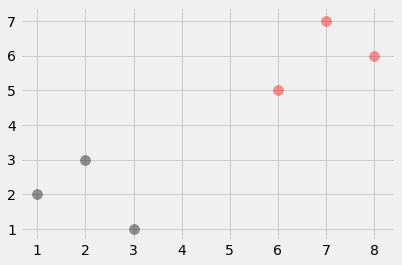

In [12]:
[plt.scatter(a[0],a[1], s=100,alpha=0.4,color=i) for i in dataset for a in dataset[i]]
plt.show()

In [13]:
def k_nearest_neighbors(data,predict,k=3):
    if len(data)>=k:
        warnings.warn("Pick a larger k")
    distances=[[np.linalg.norm(np.array(a)-np.array(predict)),i] for i in data for a in data[i]]
    votes=[i[1] for i in sorted(distances)[:k]]
    result=Counter(votes).most_common(1)[0][0]
    return result

result=k_nearest_neighbors(dataset, predict=new_features,k=3)

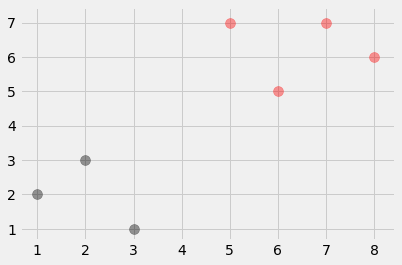

In [14]:
[plt.scatter(a[0],a[1], s=100,alpha=0.4,color=i) for i in dataset for a in dataset[i]]
plt.scatter(new_features[0],new_features[1], s=100, alpha=0.4,color=result)
plt.show()

# Use our algorithm on the cancer dataset

In [15]:
import random
df_new=df.drop(['id'],1)

full_data=df_new.astype(float).values.tolist()
#print(full_data)
random.shuffle(full_data)
train_size=0.8
train_index=int(train_size*len(X))
#print (len(X),train_size,train_index)
train_data=full_data[:train_index]
test_data=full_data[train_index:]
train_dic={2:[],4:[]};test_dic={2:[],4:[]}
for i in train_data:
    train_dic[i[-1]].append(i[:-1])
for i in test_data:
    test_dic[i[-1]].append(i[:-1])
    
correct=0;total=0

for i in test_dic:
    for a in test_dic[i]:
        #print (a,i)
        vote=k_nearest_neighbors(train_dic,a,k=5)
        if vote==i:
            correct+=1
        total+=1

print ("accuracy:",correct/total)
            

accuracy: 0.9785714285714285


# Difference between confidence and accuracy

In [16]:
def k_nearest_neighbors_with_confidence(data,predict,k=3):
    if len(data)>=k:
        warnings.warn("Pick a larger k")
    distances=[[np.linalg.norm(np.array(a)-np.array(predict)),i] for i in data for a in data[i]]
    votes=[i[1] for i in sorted(distances)[:k]]
    result=Counter(votes).most_common(1)[0][0]
    conf=Counter(votes).most_common(1)[0][1]/k
    return result,conf


for i in test_dic:
    for a in test_dic[i]:
        vote,conf=k_nearest_neighbors_with_confidence(train_dic,a,k=5)
        if vote==i and conf>0.8:
            correct+=1
        if conf <0.8:
            print (vote,conf)
        total+=1

print ("accuracy given 80% conf:",correct/total)
            

2 0.6
2 0.6
2 0.6
2 0.6
2 0.6
4 0.6
accuracy given 80% conf: 0.95


# Compare KNN algorithm with scikit-learn

In [21]:
accuracies_knn=[];N=25;accuracies_scikit=[]
for i in range(N):
    random.shuffle(full_data)
    train_size=0.8
    train_index=int(train_size*len(X))
    train_data=full_data[:train_index]
    test_data=full_data[train_index:]
    train_dic={2:[],4:[]};test_dic={2:[],4:[]}
    for i in train_data:
        train_dic[i[-1]].append(i[:-1])
    for i in test_data:
        test_dic[i[-1]].append(i[:-1])  
    correct=0;total=0
    for i in test_dic:
        for a in test_dic[i]:
            vote=k_nearest_neighbors(train_dic,a,k=5)
            if vote==i:
                correct+=1
            total+=1
        accuracies_knn.append(correct/total)

    X_train, X_test, y_train, y_test=train_test_split(X,y, test_size=0.2)
    clf=neighbors.KNeighborsClassifier();
    clf.fit(X_train,y_train)
    accuracy=clf.score(X_test,y_test)
    accuracies_scikit.append(accuracy)

print ("total acc from knn:", sum(accuracies_knn)/len(accuracies_knn))
print ("total acc from scikit:", sum(accuracies_scikit)/len(accuracies_scikit))


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

total acc from knn: 0.975333141742065
total acc from scikit: 0.966285714286
